In [1]:
#!pip install torchensemble
!pip install git+https://github.com/GautamSharma11/Ensemble-Pytorch

  Cloning https://github.com/GautamSharma11/Ensemble-Pytorch to /tmp/pip-req-build-zq7lw1oz
  Running command git clone --filter=blob:none --quiet https://github.com/GautamSharma11/Ensemble-Pytorch /tmp/pip-req-build-zq7lw1oz
  Resolved https://github.com/GautamSharma11/Ensemble-Pytorch to commit a3cd93cadca62961d6ea5ed6354cc20782eef3dd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torchensemble: filename=torchensemble-0.2.0-py3-none-any.whl size=45419 sha256=80d3d5ee801c855dab5b34caeaf25466dc4495a3949ef100d9519523697b0cd4
  Stored in directory: /tmp/pip-ephem-wheel-cache-4e88l2rj/wheels/fa/83/72/c452c15674866fbf732cf2345421fa01086fc1caac594513ce
Successfully built torchensemble


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.datasets import make_classification
from tqdm import tqdm
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torchinfo import summary
import torchvision.models as models
import copy
import os
from torchensemble import BaggingClassifier
from torchensemble.utils import io
import torchvision

In [3]:
batch_size = 32
img_size = 224
epochs = 100
learning_rate = 1e-3
weight_decay = 0.0001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_estim = 10

In [4]:
train_transform = v2.Compose([
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
    v2.RandomRotation(degrees = 10),
    v2.Grayscale(num_output_channels=3),
    #v2.RandomEqualize(),
    #v2.GaussianBlur(kernel_size = 5),
    v2.RandomHorizontalFlip(),
    v2.Resize((img_size, img_size)),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = v2.Compose([
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
    v2.Grayscale(num_output_channels=3),
    v2.Resize((img_size, img_size)),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
import random
import numpy as np
from torch.utils.data.sampler import Sampler

# Copy the PriorityTree and MixedPrioritizedSampler classes here

class PriorityTree(object):
    def __init__(self, capacity, fixed_weights=None, fixed_scale=1.0, init_weight=1.0):
        assert fixed_weights is None or len(fixed_weights) == capacity
        self._capacity = capacity
        self._tree_size = 2 * capacity - 1
        self.fixed_scale = fixed_scale
        self.fixed_weights = np.zeros(self._capacity) if fixed_weights is None else fixed_weights
        self.tree = np.zeros(self._tree_size)
        self._initialized = False
        self.initialize(init_weight)

    def initialize(self, init_weight):
        if self.fixed_weights.sum() > 0 and init_weight > 0:
            self.fixed_weights *= self.fixed_scale * init_weight * self.capacity / self.fixed_weights.sum()
        print('FixedWeights: {}'.format(self.fixed_weights.sum()))
        self.update_whole(init_weight + self.fixed_weights)
        self._initialized = True

    def reset_fixed_weights(self, fixed_weights, rescale=False):
        adaptive_weights = self.get_adaptive_weights()
        fixed_sum = fixed_weights.sum()
        if rescale and fixed_sum > 0:
            scale = self.fixed_scale * adaptive_weights.sum() / fixed_sum
            self.fixed_weights = fixed_weights * scale
        else:
            self.fixed_weights = fixed_weights
        self.update_whole(self.fixed_weights + adaptive_weights)

    def update_whole(self, total_weights):
        lefti = self.pointer_to_treeidx(0)
        righti = self.pointer_to_treeidx(self.capacity-1)
        self.tree[lefti:righti+1] = total_weights
        while lefti != 0 and righti != 0:
            lefti = (lefti - 1) // 2 if lefti != 0 else 0
            righti = (righti - 1) // 2 if righti != 0 else 0
            for i in range(righti, lefti-1, -1):
                self.tree[i] = self.tree[2*i+1] + self.tree[2*i+2]

    def get_adaptive_weights(self):
        return self.get_total_weights() - self.fixed_weights

    def get_total_weights(self):
        lefti = self.pointer_to_treeidx(0)
        righti = self.pointer_to_treeidx(self.capacity-1)
        return self.tree[lefti:righti+1]

    @property
    def size(self):
        return self._tree_size

    @property
    def capacity(self):
        return self._capacity

    def pointer_to_treeidx(self, pointer):
        assert pointer < self.capacity
        return int(pointer + self.capacity - 1)

    def update(self, pointer, priority):
        assert pointer < self.capacity
        tree_idx = self.pointer_to_treeidx(pointer)
        priority += self.fixed_weights[pointer]
        delta = priority - self.tree[tree_idx]
        self.tree[tree_idx] = priority
        while tree_idx != 0:
            tree_idx = (tree_idx - 1) // 2
            self.tree[tree_idx] += delta

    def get_leaf(self, value):
        assert self._initialized, 'PriorityTree not initialized!!!!'
        assert self.total > 0, 'No priority weights set!!'
        parent = 0
        while True:
            left_child = 2 * parent + 1
            right_child = 2 * parent + 2
            if left_child >= len(self.tree):
                tgt_leaf = parent
                break
            if value < self.tree[left_child]:
                parent = left_child
            else:
                value -= self.tree[left_child]
                parent = right_child
        data_idx = tgt_leaf - self.capacity + 1
        return data_idx, self.tree[tgt_leaf]

    @property
    def total(self):
        assert self._initialized, 'PriorityTree not initialized!!!!'
        return self.tree[0]

    @property
    def max(self):
        return np.max(self.tree[-self.capacity:])

    @property
    def min(self):
        assert self._initialized, 'PriorityTree not initialized!!!!'
        return np.min(self.tree[-self.capacity:])

    def get_weights(self):
        return {'fixed_weights': self.fixed_weights, 'total_weights': self.get_total_weights()}


class MixedPrioritizedSampler(Sampler):
    def __init__(self, dataset, balance_scale=1.0, fixed_scale=1.0, lam=None, epochs=90, cycle=0, nroot=None, manual_only=False, rescale=False, root_decay=None, decay_gap=30, ptype='score', alpha=1.0):
        self.dataset = dataset
        self.balance_scale = balance_scale
        self.fixed_scale = fixed_scale
        self.epochs = epochs
        self.lam = lam
        self.cycle = cycle
        self.nroot = nroot
        self.rescale = rescale
        self.manual_only = manual_only
        self.root_decay = root_decay
        self.decay_gap = decay_gap
        self.ptype = ptype
        self.num_samples = len(dataset)
        self.alpha = alpha

        if self.root_decay in ['exp', 'linear', 'autoexp']:
            self.lam = 1
            self.manual_only = True
            self.nroot = 1
            if self.root_decay == 'autoexp':
                self.decay_gap = 1
                self.decay_factor = np.power(nroot, 1/(self.epochs-1))
        else:
            assert self.root_decay is None
            assert self.nroot is None or self.nroot >= 2
        print("====> Decay GAP: {}".format(self.decay_gap))

        if self.lam is None:
            self.freeze = False
            if cycle == 0:
                self.lams = np.linspace(0, 1, epochs)
            elif cycle == 1:
                self.lams = np.concatenate([np.linspace(0,1,epochs//3)] * 3)
            elif cycle == 2:
                self.lams = np.concatenate([np.linspace(0,1,epochs//3), np.linspace(0,1,epochs//3)[::-1], np.linspace(0,1,epochs//3)])
            else:
                raise NotImplementedError('cycle = {} not implemented'.format(cycle))
        else:
            self.lams = [self.lam]
            self.freeze = True

        self.cls_cnts = []
        self.labels = labels = np.array(self.dataset.targets)
        for l in np.unique(labels):
            self.cls_cnts.append(np.sum(labels==l))
        self.num_classes = len(self.cls_cnts)
        self.cnts = np.array(self.cls_cnts).astype(float)

        self.cls_idxs = [[] for _ in range(self.num_classes)]
        for i, label in enumerate(self.dataset.targets):
            self.cls_idxs[label].append(i)
        for ci in range(self.num_classes):
            self.cls_idxs[ci] = np.array(self.cls_idxs[ci])

        self.balanced_weights = self.get_balanced_weights(self.nroot)
        self.manual_weights = self.get_manual_weights(self.lams[0])

        if self.ptype == 'score':
            self.init_weight = 1.
        elif self.ptype in ['CE', 'entropy']:
            self.init_weight = 6.9
        else:
            raise NotImplementedError('ptype {} not implemented'.format(self.ptype))
        if self.manual_only:
            self.init_weight = 0.
        self.init_weight = np.power(self.init_weight, self.alpha)
        self.ptree = PriorityTree(self.num_samples, self.manual_weights, fixed_scale=self.fixed_scale, init_weight=self.init_weight)

    def get_manual_weights(self, lam):
        if lam == 1:
            manual_weights = self.balanced_weights
        elif lam == 0:
            manual_weights = np.ones(len(self.balanced_weights))
        else:
            manual_weights = self.balanced_weights * lam + (1-lam)
        return manual_weights

    def get_balanced_weights(self, nroot):
        cnts = self.cnts
        if nroot is None:
            cls_ws = cnts.min() / cnts
        elif nroot >= 1:
            cls_ws = cnts / cnts.sum()
            cls_ws = np.power(cls_ws, 1./nroot) * cnts.sum()
            cls_ws = cls_ws / cnts
        else:
            raise NotImplementedError('root:{} not implemented'.format(nroot))

        balanced_weights = np.zeros(self.num_samples)
        for ci in range(self.num_classes):
            balanced_weights[self.cls_idxs[ci]] = cls_ws[ci]

        balanced_weights *= self.num_samples / balanced_weights.sum() * self.balance_scale
        return balanced_weights

    def __iter__(self):
        for _ in range(self.num_samples):
            w = random.random() * self.ptree.total
            i, pri = self.ptree.get_leaf(w)
            yield i

    def __len__(self):
        return self.num_samples

    def reset_weights(self, epoch):
        if not self.freeze and self.fixed_scale > 0:
            if epoch >= self.epochs:
                e = self.epochs - 1
            elif epoch < 1:
                e = 0
            else:
                e = epoch
            self.manual_weights = self.get_manual_weights(self.lams[e])
            self.ptree.reset_fixed_weights(self.manual_weights, self.rescale)

        if self.root_decay in ['exp', 'linear', 'autoexp'] and epoch % self.decay_gap == 0:
            if self.root_decay == 'exp':
                self.nroot *= 2
            elif self.root_decay == 'linear':
                self.nroot += 1
            elif self.root_decay == 'autoexp':
                self.nroot = np.power(self.decay_factor, epoch)

            bw = self.get_balanced_weights(self.nroot)
            self.ptree.reset_fixed_weights(bw)

    def update_weights(self, inds, weights):
        if not self.manual_only:
            weights = np.clip(weights, 0, self.init_weight)
            weights = np.power(weights, self.alpha)
            for i, w in zip(inds, weights):
                self.ptree.update(i, w)

    def get_weights(self):
        return self.ptree.get_weights()

def get_sampler():
    return MixedPrioritizedSampler

In [6]:
train_dataset = ImageFolder(root = "/kaggle/input/fer2013/train", transform = train_transform)
sampler = MixedPrioritizedSampler(train_dataset , lam = 1.0 , manual_only=True , nroot = 2.0 , epochs = epochs)
train_loader = DataLoader(train_dataset, batch_size = batch_size,sampler=sampler)
val_dataset = ImageFolder(root = "/kaggle/input/fer2013/test", transform = test_transform)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False)

====> Decay GAP: 30
FixedWeights: 28708.999999999996


In [8]:
class SEResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1, r = 16):
        super(SEResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1,bias = False)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1,bias = False)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.se = SEBlock(out_ch, reduction= r)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, padding=0,bias = False),
                nn.BatchNorm2d(out_ch)
            )
            
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.se(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.squeeze(x).view(b, c)
        y = self.excitation(y).view(b, c, 1, 1)
        return x * y.expand_as(x)
    


class ResNet18withSE(nn.Module):
    def __init__(self, num_classes=7):
        super(ResNet18withSE, self).__init__()
        
        self.drop = nn.Dropout(0.3)
        
        self.conv = nn.Conv2d(3,64,kernel_size = 7 ,stride = 2, padding = 3 , bias = False)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.max = nn.MaxPool2d(kernel_size = 3, stride=2,padding = 1)
        
        # Residual blocks
        self.block1 = SEResidualBlock(64,64,stride = 1)
        self.block2 = SEResidualBlock(64,64,stride = 1)
        
        self.block3 = SEResidualBlock(64,128,stride = 2)
        self.block4 = SEResidualBlock(128,128,stride = 1)
        
        self.block5 = SEResidualBlock(128,256,stride = 2)
        self.block6 = SEResidualBlock(256,256,stride = 1)
        
        self.block7 = SEResidualBlock(256,512,stride = 2)
        self.block8 = SEResidualBlock(512,512,stride = 1)
        
        # Global Average Pooling and Fully Connected Layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc = nn.Linear(512, num_classes)
        #self.fc1 = nn.Linear(256, 128)
        #self.fc2 = nn.Linear(128, num_classes)
        
    
    def forward(self, x):
        # Initial layers

        x = self.relu(self.bn(self.conv(x)))
        x = self.max(x)
        
        x = self.block1(x)
        x = self.drop(x)
        
        x = self.block2(x)
        x = self.drop(x)
        
        x = self.block3(x)
        x = self.drop(x)
        
        x = self.block4(x)
        x = self.drop(x)

        x = self.block5(x)
        x = self.drop(x)

        x = self.block6(x)
        x = self.drop(x)

        x = self.block7(x)
        x = self.drop(x)

        x = self.block8(x)
        x = self.drop(x)
        
        # Global Average Pooling
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        
        x = self.fc(x)
        
        return x


In [8]:
resnet18_se = ResNet18withSE()
resnet18_se = resnet18_se.to(device)
summary(resnet18_se,input_size=(1,3,img_size,img_size))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet18withSE                           [1, 7]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─SEResidualBlock: 1-5                   [1, 64, 56, 56]           --
│    └─Conv2d: 2-1                       [1, 64, 56, 56]           36,864
│    └─BatchNorm2d: 2-2                  [1, 64, 56, 56]           128
│    └─Conv2d: 2-3                       [1, 64, 56, 56]           36,864
│    └─BatchNorm2d: 2-4                  [1, 64, 56, 56]           128
│    └─SEBlock: 2-5                      [1, 64, 56, 56]           --
│    │    └─AdaptiveAvgPool2d: 3-1       [1, 64, 1, 1]             --
│    │    └─Sequential: 3-2              [1, 64]                   512


In [9]:
torch.backends.cudnn.benchmark = True

In [10]:
# from collections import Counter

# pos_weights = torch.ones(7)
# # Calculate class weights for countering class imbalance
# class_counts = Counter(train_dataset.targets)
# total_samples = sum(class_counts.values())
# pos_weights = torch.tensor([total_samples / class_counts[i] for i in range(len(class_counts))])
# pos_weights = pos_weights.to(device)
# criterion = nn.CrossEntropyLoss(pos_weights)
class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__(weight, reduction=reduction)
        self.gamma = gamma
        self.weight = weight  # Weight parameter acts as alpha for class balancing

    def forward(self, input, target):
        # Compute Cross-Entropy Loss
        ce_loss = F.cross_entropy(input, target, reduction='none', weight=self.weight)
        pt = torch.exp(-ce_loss)  # Probability/Likelihood of the true class
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        
        # Apply reduction
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:  # 'none'
            return focal_loss


#criterion = FocalLoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18_se.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-5)

def train(model, train_loader, val_loader, criterion, optimizer, epochs=100, scheduler=None):
    best_acc = 0
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        for images, labels in tqdm(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += (outputs.argmax(1) == labels).sum().item()
        train_loss /= len(train_loader.dataset)
        train_acc /= len(train_loader.dataset)
        
        model.eval()
        val_loss = 0
        val_acc = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.argmax(1) == labels).sum().item()
        val_loss /= len(val_loader.dataset)
        val_acc /= len(val_loader.dataset)
        
        if scheduler:
            scheduler.step(val_acc)
        
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    return best_acc

In [ ]:
train(resnet18_se, train_loader, val_loader, criterion, optimizer, epochs=epochs, scheduler=scheduler)

In [12]:
from sklearn.metrics import classification_report
y_true = []
y_pred = []
for images, labels in tqdm(val_loader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = resnet18_se(images)
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(outputs.argmax(1).cpu().numpy())
    
print(classification_report(y_true, y_pred, target_names= ['angry','disgust','fear','happy','neutral','sad','surprise']))

100%|██████████| 225/225 [00:17<00:00, 12.83it/s]

              precision    recall  f1-score   support

       angry       0.61      0.50      0.55       958
     disgust       0.47      0.68      0.56       111
        fear       0.57      0.36      0.44      1024
       happy       0.77      0.92      0.84      1774
     neutral       0.55      0.69      0.62      1233
         sad       0.56      0.51      0.54      1247
    surprise       0.79      0.75      0.77       831

    accuracy                           0.65      7178
   macro avg       0.62      0.63      0.62      7178
weighted avg       0.65      0.65      0.64      7178



In [10]:
ensemble = BaggingClassifier(estimator= ResNet18withSE(),n_estimators= n_estim ,cuda=True,n_jobs= 4)
io.load(model = ensemble,save_dir='/kaggle/working/bagging_newse')

In [11]:
len(ensemble.estimators_)

10

In [ ]:
ensemble.set_optimizer(
    "Adam",                                 # type of parameter optimizer
    lr=learning_rate,                       # learning rate of parameter optimizer
    weight_decay=weight_decay,              # weight decay of parameter optimizer
)
ensemble.set_scheduler(
    "CosineAnnealingWarmRestarts",                    # type of learning rate scheduler
    T_0=10, 
    T_mult=2, 
    eta_min=1e-5,                         # additional arguments on the scheduler
)
ensemble.fit(train_loader=train_loader,epochs=epochs,save_dir="/kaggle/working/bagging_newse",save_model=True,test_loader=val_loader,log_interval=400)

Epoch: 000 | Validation Acc: 68.557 % | Historical Best: 68.557 %
Epoch: 001 | Validation Acc: 68.376 % | Historical Best: 68.557 %
Epoch: 002 | Validation Acc: 68.933 % | Historical Best: 68.933 %
Epoch: 003 | Validation Acc: 69.379 % | Historical Best: 69.379 %
Epoch: 004 | Validation Acc: 69.615 % | Historical Best: 69.615 %
Epoch: 005 | Validation Acc: 69.643 % | Historical Best: 69.643 %
Epoch: 006 | Validation Acc: 70.256 % | Historical Best: 70.256 %
Epoch: 007 | Validation Acc: 70.841 % | Historical Best: 70.841 %
Epoch: 008 | Validation Acc: 70.674 % | Historical Best: 70.841 %
Epoch: 009 | Validation Acc: 70.716 % | Historical Best: 70.841 %
Epoch: 010 | Validation Acc: 68.821 % | Historical Best: 70.841 %
Epoch: 011 | Validation Acc: 68.975 % | Historical Best: 70.841 %
Epoch: 012 | Validation Acc: 68.877 % | Historical Best: 70.841 %
Epoch: 013 | Validation Acc: 69.211 % | Historical Best: 70.841 %
Epoch: 014 | Validation Acc: 69.114 % | Historical Best: 70.841 %
Epoch: 015

In [9]:
test_model = BaggingClassifier(estimator= ResNet18withSE(),n_estimators= n_estim ,cuda=True)
io.load(model=test_model,save_dir='/kaggle/working/bagging_newse')

In [10]:
len(test_model.estimators_)

10

In [20]:
test_model.evaluate(train_loader,return_loss= True)

(92.80365042321223, 1.3570398092269897)

In [11]:
test_model.evaluate(val_loader,return_loss= True)

(71.05043187517414, 1.5060251951217651)

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_test = []
y_pred = []
with torch.no_grad():
    for inputs, labels in train_loader:
        # Move inputs and labels to the same device as the model
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Perform forward pass
        outputs = test_model(inputs)
        
        # Get the predicted class (index of the maximum value in outputs)
        _, preds = torch.max(outputs, 1)

        # Append true and predicted labels
        y_test.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())



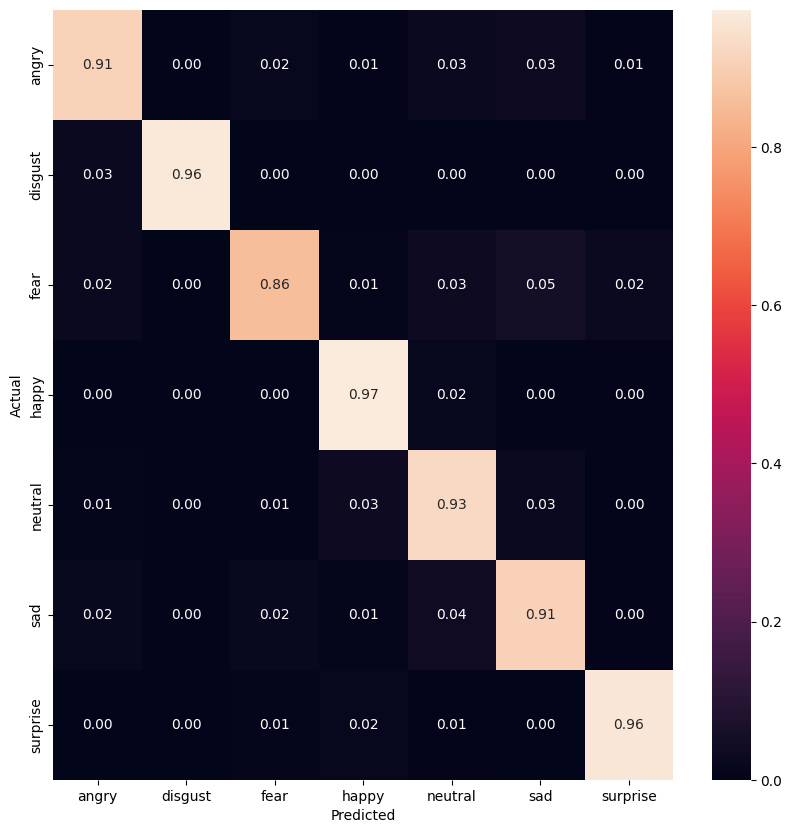

In [19]:
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
target_names = ['angry','disgust','fear','happy','neutral','sad','surprise']
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)